In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud 
from sklearn import cluster

In [3]:
df=pd.read_csv('obama_clean.csv')
def TFIDF(ls):
    #class call
    transformer = TfidfTransformer()
    #Convert words in text to word frequency matrix
    vectorizer = CountVectorizer(min_df=0.4)
    X = vectorizer.fit_transform(ls)
    #Statistical word frequency matrix X into TF-IDF value
    tfidf = transformer.fit_transform(X)
     #View the data structure tfidf[i][j] represents the tf-idf weight in the i-type text
    return tfidf.toarray()
X=TFIDF(df['clean_content'].tolist())

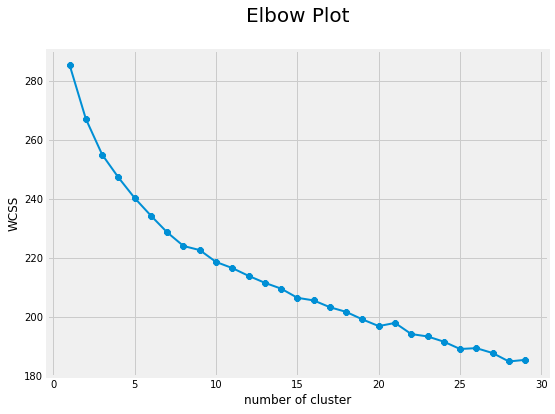

In [6]:
plt.style.use('fivethirtyeight')
%matplotlib inline
wcss= []
for k in range(1, 30):
    kmeans = KMeans(n_clusters = k, init = 'k-means++',random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(range(1, 30), wcss, linewidth = 2, marker = '8')
plt.title('Elbow Plot\n', fontsize = 20)
plt.xlabel('number of cluster')
plt.ylabel('WCSS')
#WCSS = sum of squared distance between each point and the centroid in a cluster
plt.show()

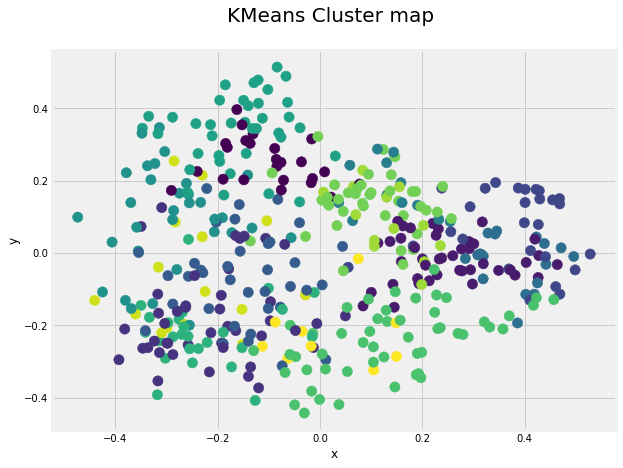

In [16]:
kmeans = KMeans(n_clusters = 15, init = 'k-means++',random_state=1)
kmeans.fit(X)

pca = PCA(2)
pca_trans = pca.fit_transform(X)
x,y = pca_trans[:,0],pca_trans[:,1]
plt.figure(figsize = (9, 7))
plt.scatter(x,y, c = kmeans.labels_, s = 105)
plt.title('KMeans Cluster map \n', fontsize = 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()
        
def run_KMeans(max_k, data):
        max_k += 1
        kmeans_results = dict()
        for k in range(2, max_k):
            kmeans = cluster.KMeans(n_clusters=k
                                    , init='k-means++'
                                    , n_init=10
                                    , tol=0.0001
                                    , random_state=1)

            kmeans_results.update({k: kmeans.fit(data)})

        return kmeans_results

In [11]:
vectorizer = TfidfVectorizer()
vecX = vectorizer.fit_transform(df["clean_content"])
tf_idf = pd.DataFrame(data = vecX.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(10, 0)

# Running Kmeans
k = 20
kmeans_results = run_KMeans(20, final_df)

best_result = 15
kmeans = kmeans_results.get(best_result)
final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)

428 rows


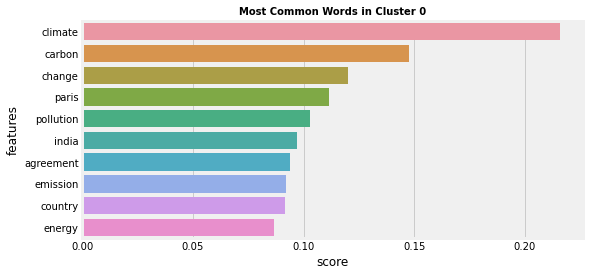

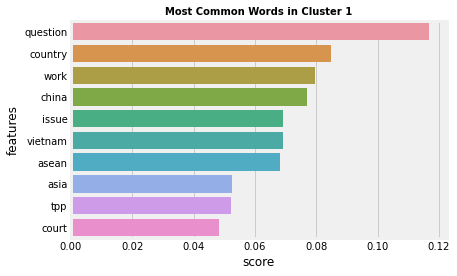

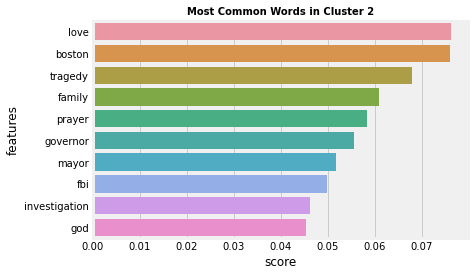

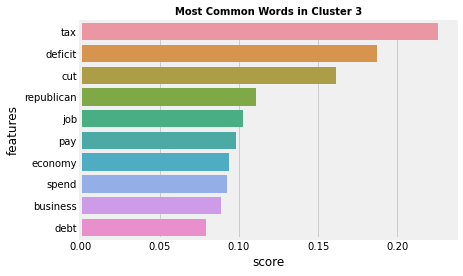

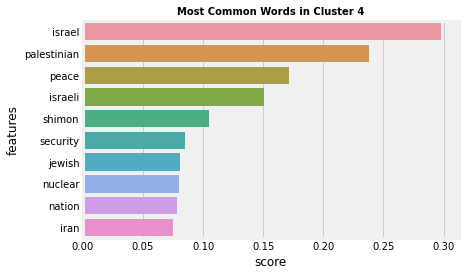

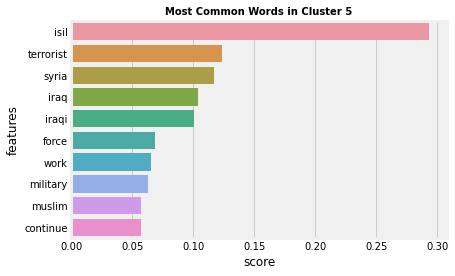

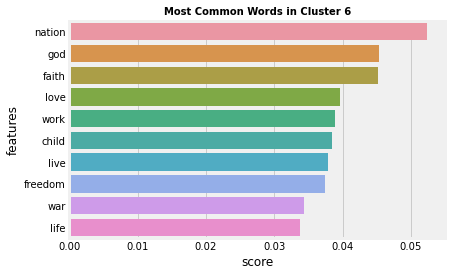

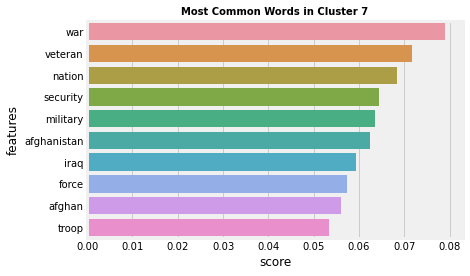

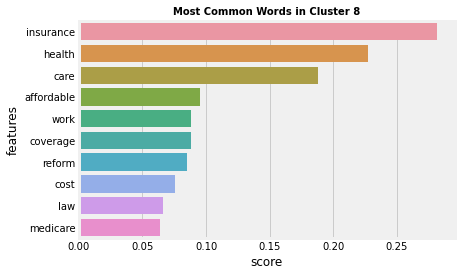

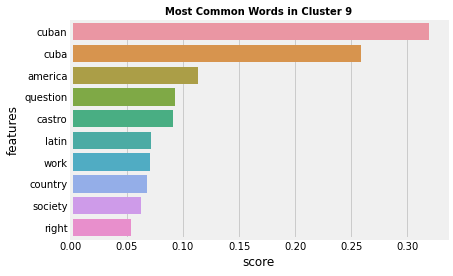

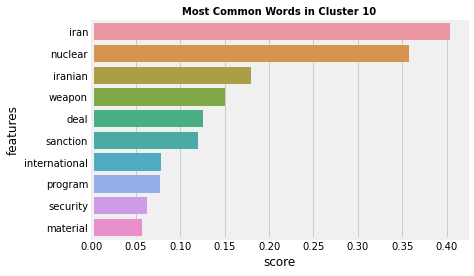

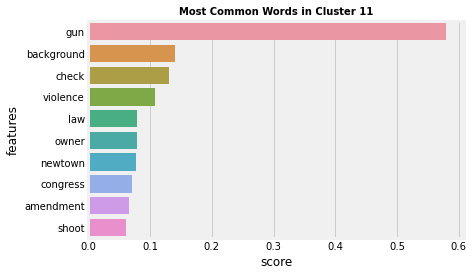

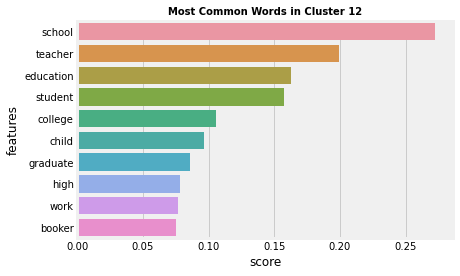

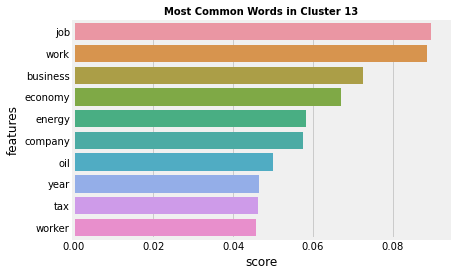

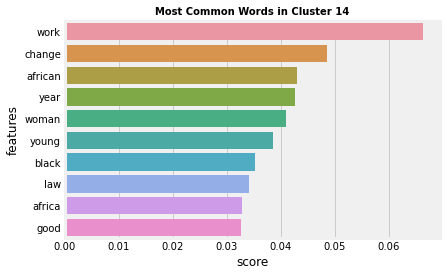

In [18]:
plotWords(dfs, 10)

In [15]:
#write the kmeans label into a csv file
df['label']=kmeans.labels_
klabel = {"label": df["label"].to_list()} 
klabel = pd.DataFrame(klabel)
klabel.to_csv('klabel.csv', index=False)